In [1]:
# Run this cell ONCE in your environment

!pip install pandas numpy scikit-learn requests beautifulsoup4 xgboost catboost matplotlib

In [2]:
import os
import json
import pickle
from datetime import datetime

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import requests
from urllib.parse import urlparse
import re
from bs4 import BeautifulSoup

# -------------------------
# Directory setup
# -------------------------
BASE_DIR = os.getcwd()
MODELS_DIR = os.path.join(BASE_DIR, "models")
ARTIFACTS_DIR = os.path.join(BASE_DIR, "artifacts")
LOGS_DIR = os.path.join(BASE_DIR, "logs")

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(ARTIFACTS_DIR, exist_ok=True)
os.makedirs(LOGS_DIR, exist_ok=True)

print("Base directory:", BASE_DIR)
print("Models:", MODELS_DIR)
print("Artifacts:", ARTIFACTS_DIR)
print("Logs:", LOGS_DIR)


Base directory: C:\Users\Kushal\OneDrive - Vasavi College Of Engineering\Desktop\Kushal\Studies\AIML\new_cbp
Models: C:\Users\Kushal\OneDrive - Vasavi College Of Engineering\Desktop\Kushal\Studies\AIML\new_cbp\models
Artifacts: C:\Users\Kushal\OneDrive - Vasavi College Of Engineering\Desktop\Kushal\Studies\AIML\new_cbp\artifacts
Logs: C:\Users\Kushal\OneDrive - Vasavi College Of Engineering\Desktop\Kushal\Studies\AIML\new_cbp\logs


In [3]:
class FeatureExtractor:
    def __init__(self, url):
        self.url = url
        self.url_features = {}
        self.html_features = {}
        self.derived_features = {}
        self.all_features = {}
        
        try:
            self.response = requests.get(
                url,
                headers={'User-Agent': 'Mozilla/5.0'},
                timeout=5
            )
            self.soup = BeautifulSoup(self.response.text, 'html.parser')
        except Exception:
            self.response = None
            self.soup = None

    def extract_url_features(self):
        try:
            parsed_url = urlparse(self.url)
            domain = parsed_url.netloc.split(':')[0]
            
            self.url_features['IsHTTPS'] = 1 if parsed_url.scheme == 'https' else 0
            self.url_features['IsDomainIP'] = 1 if re.match(r"^\d{1,3}(\.\d{1,3}){3}$", domain) else 0
            
            try:
                self.url_features['TLD'] = domain.split('.')[-1]
            except Exception:
                self.url_features['TLD'] = ""
                
            subdomains = domain.split('.')
            self.url_features['NoOfSubDomain'] = len(subdomains[:-2]) if len(subdomains) > 2 else 0
            
            self.url_features['URLLength'] = len(self.url)
            self.url_features['NoOfDots'] = self.url.count('.')
            self.url_features['NoOfObfuscatedChar'] = sum(self.url.count(c) for c in ['%', '@', '$', '!', '+'])
            self.url_features['NoOfEqual'] = self.url.count('=')
            self.url_features['NoOfQmark'] = self.url.count('?')
            self.url_features['NoOfAmp'] = self.url.count('&')
            self.url_features['NoOfDigits'] = sum(c.isdigit() for c in self.url)
            
        except Exception:
            keys = ['IsHTTPS', 'IsDomainIP', 'TLD', 'URLLength', 'NoOfSubDomain', 'NoOfDots', 
                    'NoOfObfuscatedChar', 'NoOfEqual', 'NoOfQmark', 'NoOfAmp', 'NoOfDigits']
            for k in keys:
                self.url_features.setdefault(k, 0)
            self.url_features['TLD'] = ""

    def extract_html_features(self):
        if self.soup is None or not self.response:
            keys = [
                'LineLength', 'HasTitle', 'HasMeta', 'HasFavicon', 'HasExternalFormSubmit', 
                'HasCopyright', 'HasSocialNetworking', 'HasPasswordField', 'HasSubmitButton', 
                'HasKeywordBank', 'HasKeywordPay', 'HasKeywordCrypto', 'NoOfPopup', 
                'NoOfiFrame', 'NoOfImage', 'NoOfJS', 'NoOfCSS', 'NoOfURLRedirect', 'NoOfHyperlink'
            ]
            for k in keys:
                self.html_features[k] = 0
            return

        html_content = self.response.text
        
        try:
            self.html_features['LineLength'] = max(len(line) for line in html_content.splitlines())
        except Exception:
            self.html_features['LineLength'] = 0
            
        self.html_features['HasTitle'] = 1 if self.soup.title else 0
        self.html_features['HasMeta'] = 1 if self.soup.find_all('meta') else 0
        self.html_features['HasFavicon'] = 1 if self.soup.find('link', rel=re.compile(r'icon', re.I)) else 0
        
        forms = self.soup.find_all('form')
        external_submit = 0
        for form in forms:
            action = form.get('action', '')
            if action and not action.startswith('/') and not action.startswith(self.url):
                external_submit = 1
                break
        self.html_features['HasExternalFormSubmit'] = external_submit
        
        lower_html = html_content.lower()
        self.html_features['HasCopyright'] = 1 if re.search(r'copyright|&copy;', lower_html) else 0
        social_keywords = ['facebook.', 'twitter.', 'instagram.', 'linkedin.', 'youtube.']
        self.html_features['HasSocialNetworking'] = 1 if any(kw in lower_html for kw in social_keywords) else 0
        
        self.html_features['HasPasswordField'] = 1 if self.soup.find('input', {'type': 'password'}) else 0
        self.html_features['HasSubmitButton'] = 1 if self.soup.find('input', {'type': 'submit'}) or self.soup.find('button', {'type': 'submit'}) else 0
        
        self.html_features['HasKeywordBank'] = 1 if re.search(r'\bbank\b', lower_html) else 0
        self.html_features['HasKeywordPay'] = 1 if re.search(r'\bpay\b', lower_html) else 0
        self.html_features['HasKeywordCrypto'] = 1 if re.search(r'\bcrypto\b', lower_html) else 0
        
        self.html_features['NoOfPopup'] = lower_html.count('popup')
        self.html_features['NoOfiFrame'] = len(self.soup.find_all('iframe'))
        self.html_features['NoOfImage'] = len(self.soup.find_all('img'))
        self.html_features['NoOfJS'] = len(self.soup.find_all('script'))
        self.html_features['NoOfCSS'] = len(self.soup.find_all('link', {'rel': 'stylesheet'}))
        self.html_features['NoOfURLRedirect'] = len(self.response.history)
        self.html_features['NoOfHyperlink'] = len(self.soup.find_all('a'))

    def craft_derived_features(self):
        u = self.url_features
        h = self.html_features
        
        url_len = u.get('URLLength', 0)
        if url_len == 0:
            self.derived_features['SuspiciousCharRatio'] = 0
        else:
            susp_chars = (
                u.get('NoOfObfuscatedChar', 0) +
                u.get('NoOfEqual', 0) +
                u.get('NoOfQmark', 0) +
                u.get('NoOfAmp', 0)
            )
            self.derived_features['SuspiciousCharRatio'] = susp_chars / url_len
        
        if url_len == 0:
            term1 = 0
        else:
            term1 = (
                u.get('URLLength', 0) +
                u.get('NoOfSubDomain', 0) +
                u.get('NoOfObfuscatedChar', 0)
            ) / url_len
        
        term2 = (u.get('NoOfEqual', 0) + u.get('NoOfAmp', 0)) / (u.get('NoOfQmark', 0) + 1)
        self.derived_features['URLComplexityScore'] = term1 + term2
        
        denominator_html = h.get('NoOfJS', 0) + h.get('NoOfCSS', 0) + h.get('NoOfiFrame', 0) + 1
        self.derived_features['HTMLContentDensity'] = (
            h.get('LineLength', 0) + h.get('NoOfImage', 0)
        ) / denominator_html
        
        denominator_interactive = h.get('LineLength', 0) + h.get('NoOfImage', 0)
        if denominator_interactive == 0:
            self.derived_features['InteractiveElementDensity'] = 0
        else:
            numerator_interactive = (
                h.get('HasSubmitButton', 0) +
                h.get('HasPasswordField', 0) +
                h.get('NoOfPopup', 0)
            )
            self.derived_features['InteractiveElementDensity'] = (
                numerator_interactive / denominator_interactive
            )

    def get_features(self):
        self.extract_url_features()
        self.extract_html_features()
        self.craft_derived_features()
        
        self.all_features.update(self.url_features)
        self.all_features.update(self.html_features)
        self.all_features.update(self.derived_features)
        
        return self.all_features


In [4]:
def save_json(data, path):
    with open(path, "w") as f:
        json.dump(data, f, indent=4)

def timestamp():
    return datetime.now().strftime("%Y%m%d_%H%M%S")


In [5]:
# Load dataset once for global reference
df = pd.read_csv("PhishOFE_ds.csv").fillna(0)

le_tld = LabelEncoder()
df['TLD'] = le_tld.fit_transform(df['TLD'].astype(str))

X = df.drop(['URL', 'label'], axis=1)
y = df['label']

# Create global train/test splits so we can reference later
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

def train_from_dataset_with_pca(
    dataset_file: str,
    model_output_path: str = None,
    n_components: int = 8
):
    """
    Train phishing URL detector with PCA (8 components) and multiple models.
    Saves:
      - Pickle with model, scaler, PCA, label encoder, feature order
      - Metrics log
      - PCA variance info
      - Processed dataset snapshot
    """
    if model_output_path is None:
        model_output_path = os.path.join(MODELS_DIR, "phishofe_model.pkl")
    
    print("Loading dataset from:", dataset_file)
    df = pd.read_csv(dataset_file).fillna(0)
    print("Dataset shape:", df.shape)
    print(df['label'].value_counts())
    
    # Encode TLD
    le_tld = LabelEncoder()
    df['TLD'] = le_tld.fit_transform(df['TLD'].astype(str))
    
    # Separate features/labels
    X = df.drop(['URL', 'label'], axis=1)
    y = df['label']
    feature_order = list(X.columns)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )
    
    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    print(f"\nPCA with {n_components} components fitted.")
    print("Explained variance ratio (per component):")
    print(pca.explained_variance_ratio_)
    print("Total variance retained:", pca.explained_variance_ratio_.sum())
    
    # -------------------------
    # Train multiple models
    # -------------------------
    models = {
        "RandomForest": RandomForestClassifier(
            n_estimators=100,
            max_depth=7,
            min_samples_leaf=3,
            n_jobs=-1,
            random_state=42
        ),
        "XGBoost": XGBClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.8,
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=42
        ),
        "CatBoost": CatBoostClassifier(
            depth=6,
            learning_rate=0.1,
            iterations=300,
            loss_function='Logloss',
            verbose=0,
            random_state=42
        )
    }
    
    metrics = {}
    best_model_name = None
    best_f1 = -1
    best_model = None
    
    for name, clf in models.items():
        print(f"\nTraining model: {name}")
        clf.fit(X_train_pca, y_train)
        y_pred = clf.predict(X_test_pca)
        
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        metrics[name] = {
            "accuracy": float(acc),
            "precision": float(prec),
            "recall": float(rec),
            "f1": float(f1)
        }
        
        print(f"{name} -> Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}")
        
        if f1 > best_f1:
            best_f1 = f1
            best_model_name = name
            best_model = clf
    
    print("\nBest model:", best_model_name, "with F1:", best_f1)
    
    # Save artifacts in one pickle (model + scaler + pca + label encoder + feature order)
    model_data = {
        "model_name": best_model_name,
        "model": best_model,
        "scaler": scaler,
        "pca": pca,
        "label_encoder": le_tld,
        "feature_order": feature_order,
        "metrics": metrics
    }
    
    with open(model_output_path, "wb") as f:
        pickle.dump(model_data, f)
    
    print(f"\n✅ Model artifacts saved to: {model_output_path}")
    
    # Save logs & PCA info
    log_stamp = timestamp()
    
    metrics_path = os.path.join(LOGS_DIR, f"training_metrics_{log_stamp}.json")
    save_json(metrics, metrics_path)
    print("Metrics saved to:", metrics_path)
    
    pca_info = {
        "n_components": n_components,
        "explained_variance_ratio": pca.explained_variance_ratio_.tolist(),
        "total_variance": float(pca.explained_variance_ratio_.sum())
    }
    pca_path = os.path.join(ARTIFACTS_DIR, f"pca_info_{log_stamp}.json")
    save_json(pca_info, pca_path)
    print("PCA info saved to:", pca_path)
    
    processed_path = os.path.join(ARTIFACTS_DIR, f"processed_sample_{log_stamp}.csv")
    df.to_csv(processed_path, index=False)
    print("Processed dataset snapshot saved to:", processed_path)
    
    return model_data


In [6]:
model_data = train_from_dataset_with_pca("PhishOFE_ds.csv", n_components=8)

Loading dataset from: PhishOFE_ds.csv
Dataset shape: (101063, 32)
0    51572
1    49491
Name: label, dtype: int64

PCA with 8 components fitted.
Explained variance ratio (per component):
[0.12865524 0.11956325 0.06133561 0.05468327 0.04798066 0.04181005
 0.03963116 0.03588984]
Total variance retained: 0.5295490822721456

Training model: RandomForest
RandomForest -> Acc: 0.9546, Prec: 0.9753, Rec: 0.9309, F1: 0.9526

Training model: XGBoost


C:\Users\Kushal\anaconda3\lib\site-packages\xgboost\training.py:199: UserWarning: [23:42:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost -> Acc: 0.9787, Prec: 0.9845, Rec: 0.9717, F1: 0.9781

Training model: CatBoost
CatBoost -> Acc: 0.9797, Prec: 0.9855, Rec: 0.9729, F1: 0.9792

Best model: CatBoost with F1: 0.9791560752414845

✅ Model artifacts saved to: C:\Users\Kushal\OneDrive - Vasavi College Of Engineering\Desktop\Kushal\Studies\AIML\new_cbp\models\phishofe_model.pkl
Metrics saved to: C:\Users\Kushal\OneDrive - Vasavi College Of Engineering\Desktop\Kushal\Studies\AIML\new_cbp\logs\training_metrics_20251120_234230.json
PCA info saved to: C:\Users\Kushal\OneDrive - Vasavi College Of Engineering\Desktop\Kushal\Studies\AIML\new_cbp\artifacts\pca_info_20251120_234230.json
Processed dataset snapshot saved to: C:\Users\Kushal\OneDrive - Vasavi College Of Engineering\Desktop\Kushal\Studies\AIML\new_cbp\artifacts\processed_sample_20251120_234230.csv


In [20]:
def print_training_summary(model_data, X_train, X_test, y_train, y_test, pca):

    print("\n" + "="*80)
    print("📌 TRAINING PIPELINE SUMMARY")
    print("="*80)

    # ---------------- Dataset Info ----------------
    print("\n🔍 Dataset Information:")
    print(f" - Total samples: {len(y_train) + len(y_test)}")
    print(f" - Training samples: {len(y_train)}")
    print(f" - Testing samples: {len(y_test)}")
    print(f" - Original feature count: {len(model_data['feature_order'])}")
    print(f" - Final PCA feature count: {pca.n_components_}")

        # ---------------- PCA Details ----------------
    print("\n📊 PCA Component Breakdown (Top Contributing Features):")
    
    components = pca.components_
    feature_names = model_data['feature_order']
    
    for idx, comp in enumerate(components):
        # Sort features by absolute weight contribution to component
        sorted_indices = np.argsort(np.abs(comp))[::-1]
        top_features = [feature_names[i] for i in sorted_indices[:5]]  # top 5 features
        
        print(f"\n🧩 Principal Component {idx+1}:")
        print(f"   - Explained Variance: {pca.explained_variance_ratio_[idx]:.4f}")
        print(f"   - Top contributing features:")
        
        for feat_idx in sorted_indices[:5]:
            print(f"       {feature_names[feat_idx]} (weight={comp[feat_idx]:.4f})")

    print(f"\n➡ Total Variance Retained: {sum(pca.explained_variance_ratio_):.4f}")

    # ---------------- Model Performance ----------------
    metrics = model_data['metrics']
    for model_name, scores in metrics.items():
        print(f"\n📌 {model_name}:")
        print(f"   - Accuracy:  {scores['accuracy']:.4f}")
        print(f"   - Precision: {scores['precision']:.4f}")
        print(f"   - Recall:    {scores['recall']:.4f}")
        print(f"   - F1 Score:  {scores['f1']:.4f}")

    # ---------------- Best Model ----------------
    best = model_data['model_name']
    print("\n" + "="*80)
    print(f"🏆 BEST MODEL SELECTED: **{best}**")
    print("="*80)

    # ---------------- Train vs Test Evaluation ----------------
    model = model_data['model']

    # predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    print("\n📈 GENERALIZATION CHECK (Train vs Test)")
    print(f" - Training Accuracy: {train_accuracy:.4f}")
    print(f" - Testing Accuracy : {test_accuracy:.4f}")
    print(f" - Training F1 Score: {train_f1:.4f}")
    print(f" - Testing F1 Score : {test_f1:.4f}")

    if abs(train_accuracy - test_accuracy) > 0.10:
        print("\n⚠️ Possible Overfitting: Large gap between train/test performance.")
    else:
        print("\n✅ No major overfitting detected.")

    print("\n" + "="*80)
    print("📦 MODEL ARTIFACTS SAVED SUCCESSFULLY")
    print("="*80)


In [21]:
print_training_summary(
    model_data=model_data,
    X_train=model_data['pca'].transform(model_data['scaler'].transform(X_train)),
    X_test=model_data['pca'].transform(model_data['scaler'].transform(X_test)),
    y_train=y_train,
    y_test=y_test,
    pca=model_data['pca']
)



📌 TRAINING PIPELINE SUMMARY

🔍 Dataset Information:
 - Total samples: 101063
 - Training samples: 80850
 - Testing samples: 20213
 - Original feature count: 30
 - Final PCA feature count: 8

📊 PCA Component Breakdown (Top Contributing Features):

🧩 Principal Component 1:
   - Explained Variance: 0.1287
   - Top contributing features:
       NoOfEqual (weight=0.4337)
       NoOfAmp (weight=0.4159)
       NoOfQmark (weight=0.3894)
       NoOfDigits (weight=0.3143)
       NoOfDots (weight=0.3064)

🧩 Principal Component 2:
   - Explained Variance: 0.1196
   - Top contributing features:
       HasSocialNetworking (weight=0.3702)
       NoOfJS (weight=0.3258)
       HasTitle (weight=0.3141)
       HasFavicon (weight=0.2715)
       HasSubmitButton (weight=0.2696)

🧩 Principal Component 3:
   - Explained Variance: 0.0613
   - Top contributing features:
       NoOfDots (weight=0.4232)
       NoOfSubDomain (weight=0.3609)
       HasFavicon (weight=-0.3169)
       HasPasswordField (weight=0.3099

In [11]:
from sklearn.metrics import confusion_matrix, roc_auc_score, RocCurveDisplay

# Get final model
final_model = model_data["model"]

# Predictions
y_test_pred = final_model.predict(model_data['pca'].transform(model_data['scaler'].transform(X_test)))

# If model supports probability prediction
if hasattr(final_model, "predict_proba"):
    y_test_proba = final_model.predict_proba(model_data['pca'].transform(model_data['scaler'].transform(X_test)))[:, 1]
else:
    # fallback: convert decision function to probability-like values
    y_test_proba = final_model.decision_function(
        model_data['pca'].transform(model_data['scaler'].transform(X_test))
    )


     ------------------------------------- 294.9/294.9 kB 19.0 MB/s eta 0:00:00


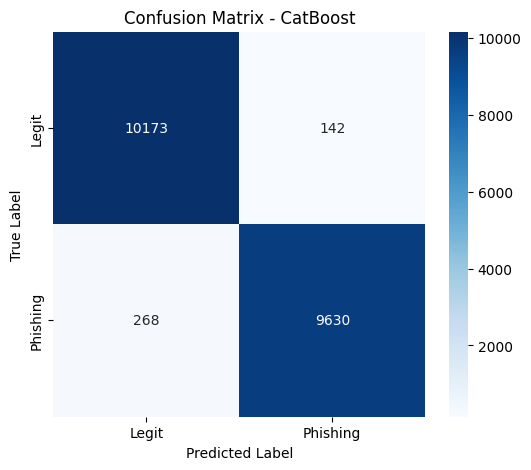

In [13]:
!pip install seaborn

import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legit", "Phishing"], yticklabels=["Legit", "Phishing"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - {model_data['model_name']}")
plt.show()


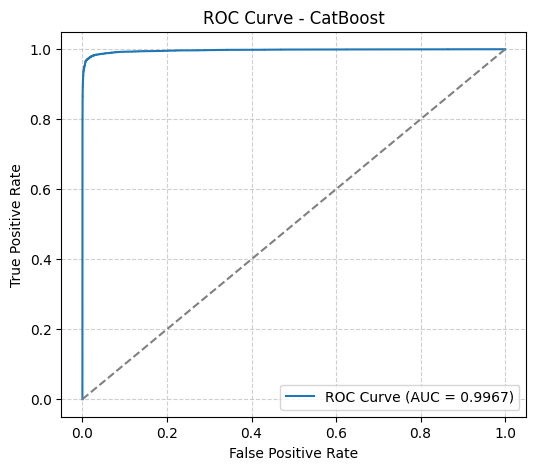


📌 AUC Score for CatBoost: 0.9967


In [14]:
from sklearn.metrics import roc_curve, auc

# Compute ROC metrics
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - {model_data['model_name']}")
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print(f"\n📌 AUC Score for {model_data['model_name']}: {roc_auc:.4f}")


In [15]:
# Create folder if not exists
VIS_DIR = os.path.join(LOGS_DIR, "visuals")
os.makedirs(VIS_DIR, exist_ok=True)

# Save confusion matrix
cm_path = os.path.join(VIS_DIR, f"confusion_matrix_{model_data['model_name']}.png")
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legit","Phishing"], yticklabels=["Legit","Phishing"])
plt.title(f"Confusion Matrix - {model_data['model_name']}")
plt.savefig(cm_path, bbox_inches='tight')
plt.close()

# Save ROC Curve
roc_path = os.path.join(VIS_DIR, f"ROC_curve_{model_data['model_name']}.png")
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc:.4f})")
plt.plot([0,1],[0,1],"--",color="gray")
plt.legend()
plt.title(f"ROC Curve - {model_data['model_name']}")
plt.savefig(roc_path, bbox_inches='tight')
plt.close()

print("\n📁 Visuals saved to:", VIS_DIR)



📁 Visuals saved to: C:\Users\Kushal\OneDrive - Vasavi College Of Engineering\Desktop\Kushal\Studies\AIML\new_cbp\logs\visuals


In [9]:
class PhishOFEDetector:
    def __init__(self, model_path: str):
        try:
            with open(model_path, "rb") as f:
                model_data = pickle.load(f)
            
            self.model_name = model_data.get("model_name", "UnknownModel")
            self.model = model_data["model"]
            self.scaler = model_data["scaler"]
            self.pca = model_data["pca"]
            self.label_encoder = model_data["label_encoder"]
            self.feature_order = model_data["feature_order"]
            
            # For safety: classes_ used during training
            self.tld_classes_ = set(self.label_encoder.classes_.tolist())
            
            print(f"Loaded model: {self.model_name}")
        except Exception as e:
            raise RuntimeError(f"Error loading model artifacts: {e}")
    
    def _prepare_features(self, url: str) -> np.ndarray:
        extractor = FeatureExtractor(url)
        features_dict = extractor.get_features()
        feature_df = pd.DataFrame([features_dict]).fillna(0)
        
        # Encode TLD
        tld_value = str(feature_df['TLD'].values[0])
        if tld_value in self.tld_classes_:
            feature_df['TLD'] = self.label_encoder.transform([tld_value])[0]
        else:
            # unseen TLD -> map to -1
            feature_df['TLD'] = -1
        
        # Align with training feature order (add missing cols as 0)
        for col in self.feature_order:
            if col not in feature_df.columns:
                feature_df[col] = 0
        
        feature_df = feature_df[self.feature_order]
        
        # Scale
        scaled = self.scaler.transform(feature_df)
        
        # PCA
        pca_features = self.pca.transform(scaled)
        return pca_features
    
    def predict(self, url: str):
        try:
            X = self._prepare_features(url)
            pred = self.model.predict(X)[0]
            
            # Not all classifiers may have predict_proba (but ours do)
            if hasattr(self.model, "predict_proba"):
                proba = self.model.predict_proba(X)[0]
                prob_legit = float(proba[0])
                prob_phish = float(proba[1])
            else:
                prob_legit = None
                prob_phish = None
            
            return {
                "url": url,
                "model": self.model_name,
                "prediction_label": int(pred),
                "prediction": "Phishing" if pred == 1 else "Legitimate",
                "phishing_probability": prob_phish,
                "legitimate_probability": prob_legit
            }
        except Exception as e:
            return {
                "status": "Error",
                "message": str(e)
            }


In [10]:
# Path must match the one used in train_from_dataset_with_pca()
model_path = os.path.join(MODELS_DIR, "phishofe_model.pkl")
detector = PhishOFEDetector(model_path)

test_url = "https://www.google.com"
result = detector.predict(test_url)
result


Loaded model: CatBoost


{'url': 'https://www.google.com',
 'model': 'CatBoost',
 'prediction_label': 0,
 'prediction': 'Legitimate',
 'phishing_probability': 0.06320246226953428,
 'legitimate_probability': 0.9367975377304657}

In [17]:
test_urls = [
    "https://www.microsoft.com/en-in/",
    "https://www.paypal.com/signin",
    "http://paypal-login-security-update.com/verify",
    "https://secure-update-appleid.com.account-validation.verify-session.cn/login",
    "https://accounts-security-google.com/login/auth"
]

results = []

for url in test_urls:
    res = detector.predict(url)
    print("\n", "-"*70)
    print(f"🔍 Testing URL: {url}")
    print(f"Prediction: {res.get('prediction', 'Error')}")
    print(f"Phishing Probability: {res.get('phishing_probability')}")
    print(f"Legitimate Probability: {res.get('legitimate_probability')}")
    results.append(res)



 ----------------------------------------------------------------------
🔍 Testing URL: https://www.microsoft.com/en-in/
Prediction: Legitimate
Phishing Probability: 0.09171341636637459
Legitimate Probability: 0.9082865836336254

 ----------------------------------------------------------------------
🔍 Testing URL: https://www.paypal.com/signin
Prediction: Legitimate
Phishing Probability: 0.03232731944454801
Legitimate Probability: 0.967672680555452

 ----------------------------------------------------------------------
🔍 Testing URL: http://paypal-login-security-update.com/verify
Prediction: Phishing
Phishing Probability: 0.9934600521130336
Legitimate Probability: 0.006539947886966435

 ----------------------------------------------------------------------
🔍 Testing URL: https://secure-update-appleid.com.account-validation.verify-session.cn/login
Prediction: Phishing
Phishing Probability: 0.9438847686148945
Legitimate Probability: 0.056115231385105546

 ------------------------------

In [19]:
test_urls = [

    # ------------------ Functional Testing ------------------
    "",  # Empty string
    "http://127.0.0.1:8080",  # Localhost / no domain structure
    "http://192.168.2.98/login.php",  # Raw IP phishing pattern
    "https://this-domain-definitely-does-not-exist-82829292929292922.com",  # Broken resolve
    "https://www.example.com/" + "a"*300,  # Extremely long URL stress test
    

    # ------------------ Robustness / Adversarial Testing ------------------
    "http://gοοgle.com",  # Homoglyph attack (Greek 'ο' not English 'o')
    "https://bit.ly/3qT2KsR",  # URL shortener (context lost until redirect)
    "http://%70%61%79%70%61%6C.com/login",  # URL encoded trick (decodes to 'paypal')
    

    # ------------------ Hard to Classify / Realistic Lookalikes ------------------
    "https://login.microsoftonline.com/consumers/oauth2/authorize",  # Legit but complex SSO
    "https://google.com.security-check.support/login",  # Fake brand layered domain
    "https://sso.us-east-2.amazonaws.com/login?client_id=abc123xyz",  # Enterprise identity redirect
    "https://appleid.apple.com-id.verify.secure-service.net/",  # Very advanced phishing
]

results = []

print("\n🚀 Running Advanced Evaluation on Stress + Attack Test URLs...\n")

for url in test_urls:
    res = detector.predict(url)
    print("-" * 100)
    print(f"🌐 URL: {url if url else '[EMPTY STRING]'}")
    print(f"Prediction          : {res.get('prediction', 'Error')}")
    print(f"Phishing Probability: {res.get('phishing_probability')}")
    print(f"Legit Probability   : {res.get('legitimate_probability')}")
    
    results.append(res)

print("\n\n📌 Test Batch Complete.")



🚀 Running Advanced Evaluation on Stress + Attack Test URLs...

----------------------------------------------------------------------------------------------------
🌐 URL: [EMPTY STRING]
Prediction          : Phishing
Phishing Probability: 0.7308269161042185
Legit Probability   : 0.26917308389578154
----------------------------------------------------------------------------------------------------
🌐 URL: http://127.0.0.1:8080
Prediction          : Phishing
Phishing Probability: 0.9999971909670703
Legit Probability   : 2.8090329297070227e-06
----------------------------------------------------------------------------------------------------
🌐 URL: http://192.168.2.98/login.php
Prediction          : Phishing
Phishing Probability: 0.9999950197310165
Legit Probability   : 4.980268983545422e-06
----------------------------------------------------------------------------------------------------
🌐 URL: https://this-domain-definitely-does-not-exist-82829292929292922.com
Prediction          : 

In [28]:
def detect(input_data, save_results=False):
    """
    Runs the phishing detector in testing mode.
    
    Parameters:
    - input_data: str (single URL) or list/tuple of URLs
    - save_results: bool (optional) -> saves output to artifacts folder
    
    Returns:
    - results: list of prediction dictionaries
    """

    # ---- Normalize Input ----
    if isinstance(input_data, str):
        # Single value -> convert to list
        test_urls = [input_data]
    elif isinstance(input_data, (list, tuple, set)):
        test_urls = list(input_data)
    else:
        raise TypeError("Input must be a string URL or a list of URLs.")
    

    print("\n🔍 Running Detector in TEST MODE...\n")
    results = []

    for url in test_urls:
        try:
            res = detector.predict(url)
        except Exception as e:
            res = {"url": url, "error": str(e)}
        
        results.append(res)

        print("-" * 100)
        print(f"🌐 URL: {url if url else '[EMPTY STRING]'}")

        if "error" in res:
            print(f"❌ Error: {res['error']}")
            continue
        
        print(f"Prediction          : {res.get('prediction_label')} ({res.get('prediction')})")
        print(f"Phishing Probability: {res.get('phishing_probability')}")
        print(f"Legit Probability   : {res.get('legitimate_probability')}")
    

    # ---- Save Results If Required ----
    if save_results:
        filename = f"test_results_{timestamp()}.csv"
        filepath = os.path.join(ARTIFACTS_DIR, filename)

        df = pd.DataFrame(results)
        df.to_csv(filepath, index=False)

        print("\n📁 Results saved to:", filepath)
    

    print("\n📌 Test Complete.\n")
    return 


In [29]:
detect("https://www.instagram.com/p/CklJ3seA7ao/")


🔍 Running Detector in TEST MODE...

----------------------------------------------------------------------------------------------------
🌐 URL: https://www.instagram.com/p/CklJ3seA7ao/
Prediction          : 1 (Phishing)
Phishing Probability: 0.9267581055550252
Legit Probability   : 0.07324189444497475

📌 Test Complete.



In [30]:
detect("https://www.instagram.com/stories/highlights/18112608208326376/")


🔍 Running Detector in TEST MODE...

----------------------------------------------------------------------------------------------------
🌐 URL: https://www.instagram.com/stories/highlights/18112608208326376/
Prediction          : 1 (Phishing)
Phishing Probability: 0.9990226371460261
Legit Probability   : 0.0009773628539738732

📌 Test Complete.



In [31]:
detect("https://www.youtube.com/shorts/RsM7Y1zey00")


🔍 Running Detector in TEST MODE...

----------------------------------------------------------------------------------------------------
🌐 URL: https://www.youtube.com/shorts/RsM7Y1zey00
Prediction          : 1 (Phishing)
Phishing Probability: 0.8081632866537766
Legit Probability   : 0.19183671334622343

📌 Test Complete.



In [32]:
detect("https://www.youtube.com/@PeopleMediaFactory")


🔍 Running Detector in TEST MODE...

----------------------------------------------------------------------------------------------------
🌐 URL: https://www.youtube.com/@PeopleMediaFactory
Prediction          : 0 (Legitimate)
Phishing Probability: 0.22764523550364482
Legit Probability   : 0.7723547644963552

📌 Test Complete.



In [33]:
detect("https://www.instagram.com/ieee_grss/p/DMxJG_3tRRs/")


🔍 Running Detector in TEST MODE...

----------------------------------------------------------------------------------------------------
🌐 URL: https://www.instagram.com/ieee_grss/p/DMxJG_3tRRs/
Prediction          : 1 (Phishing)
Phishing Probability: 0.9188390259375165
Legit Probability   : 0.08116097406248346

📌 Test Complete.

